# Updated Baseline
The code and results below correspond to an upgraded baseline upon the Landslide4Sense dataset. The actual baseline suggested by the dataset was 56% in F1 and 76% in MLou. Here, I replicated the baseline and added my own touches to see how it affects our results.

In [1]:
# install and configure
!pip install --quiet kaggle
from google.colab import files
files.upload()                         # upload kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download tekbahadurkshetri/landslide4sense \
-p /content/landslide_data --unzip

Dataset URL: https://www.kaggle.com/datasets/tekbahadurkshetri/landslide4sense
License(s): other
100% 2.84G/2.85G [00:10<00:00, 413MB/s]
100% 2.85G/2.85G [00:10<00:00, 301MB/s]


## Initial Setup and Tests
General focus here is to just get a feel of the data, its dimensions and how we can use for eventual training. Below are cells that:


*   Mount our drive (where the data is located) and initalizes paths.
*   pip install and import all required packages for our baseline.



In [3]:
BASE_PATH = "/content"
DATA_PATH = f"{BASE_PATH}/landslide_data"


In [4]:
!pip install pandas numpy torch torchvision torchaudio h5py -q
!pip install opencv-python matplotlib segmentation-models-pytorch albumentations tqdm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 11.0 MB/s eta 0:00:00


In [21]:
import torch
import numpy as np
import os
import cv2
import matplotlib as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import h5py
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data and loading Dataset class
This Section focuses on initializing our .h5 image data. I went through several resources to understand this datatype.

In [6]:
# Test Data and check type, verified it here.

sample_path = f"{DATA_PATH}/TrainData/img/image_1.h5"  # adjust this to match one of your file names

with h5py.File(sample_path, 'r') as f:
    print(list(f.keys()))  # shows all datasets inside the file
    data = f['img'][:]   # try reading the image data (dataset name might be different, we’ll check)
    print("Data shape:", data.shape)

mask_path = f"{DATA_PATH}/TrainData/mask/mask_1.h5"

with h5py.File(mask_path, 'r') as f:
    print(f.keys())  # find correct key
    mask = f['mask'][:]  # or whatever the key is
    print("Mask shape:", mask.shape)
    print("Unique values:", np.unique(mask))


['img']
Data shape: (128, 128, 14)
<KeysViewHDF5 ['mask']>
Mask shape: (128, 128)
Unique values: [0 1]


In [40]:
# Load and sketch the Dataset class


class LandSlideHSDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, mask_paths, transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # 1. Load image
        with h5py.File(self.img_paths[idx], 'r') as f:
            img = f['img'][:]  # (H, W, C)

        # 2. Load mask
        with h5py.File(self.mask_paths[idx], 'r') as f:
            m = f['mask'][:]   # (H, W)

        # Apply transform if any
        if self.transform:
            # Albumentations works with HWC format and expects masks as numpy arrays
            transformed = self.transform(image=img, mask=m)
            img = transformed['image']
            m = transformed['mask']

        # 3. Transpose image to (C, H, W)
        img = np.transpose(img, (2, 0, 1)).astype(np.float32)

        # 4. Convert to tensors
        img_tensor = torch.from_numpy(img)  # shape: (C, H, W)
        mask_tensor = torch.from_numpy(m.astype(np.float32))  # shape: (H, W)

        # 5. Add channel dim to mask -> (1, H, W)
        mask_tensor = mask_tensor.unsqueeze(0)

        # 6. Return pair
        return img_tensor, mask_tensor

# Define the transform
data_transform = A.Compose([
    A.Resize(256, 256), # Resize to 256x256
    # Add other transformations here if needed
])


ds = LandSlideHSDataset(
    img_paths=[
        f"{DATA_PATH}/TrainData/img/image_1.h5",
        f"{DATA_PATH}/TrainData/img/image_2.h5"
    ],
    mask_paths=[
        f"{DATA_PATH}/TrainData/mask/mask_1.h5",
        f"{DATA_PATH}/TrainData/mask/mask_2.h5"
    ],
    transform=data_transform # Pass the transform to the dataset
)
print(len(ds))
i, m = ds[0]
print("Image shape:", i.shape)
print("Mask shape:", m.shape)

2
Image shape: torch.Size([14, 256, 256])
Mask shape: torch.Size([1, 256, 256])


In [41]:
# Use Dataloaders and split the Training data into a 80/20 Split.

img_dir  = f"{DATA_PATH}/TrainData/img"
mask_dir = f"{DATA_PATH}/TrainData/mask"

all_img_paths = sorted([
    os.path.join(img_dir,  fname)
    for fname in os.listdir(img_dir)
    if fname.endswith('.h5')
])

all_mask_paths = sorted([
    os.path.join(mask_dir, fname)
    for fname in os.listdir(mask_dir)
    if fname.endswith('.h5')
])

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# This will shuffle and split in one go:
img_train, img_val, mask_train, mask_val = train_test_split(
    all_img_paths, all_mask_paths,
    test_size=0.2,      # 20% validation
    random_state=42     # fixed seed for reproducibility
)

# Assuming data_transform is defined in a previous cell (cell_id: LobQ9MR4lcIh)
train_ds = LandSlideHSDataset(img_train, mask_train, transform=data_transform)
val_ds   = LandSlideHSDataset(img_val,   mask_val,   transform=data_transform)


from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2)

# Check lengths & shapes
print(len(train_loader), len(val_loader))
imgs, msks = next(iter(train_loader))
print(imgs.shape, msks.shape)

380 95
torch.Size([8, 14, 128, 128]) torch.Size([8, 1, 128, 128])


## Model Initialization

i initialize and set up the loss, network and optimizer here.

In [27]:
!pip install smp.encoders


ERROR: Could not find a version that satisfies the requirement smp.encoders (from versions: none)
ERROR: No matching distribution found for smp.encoders


In [42]:
# ─── Cell: Model ▸ Device ▸ Quick-train Sanity Check ─────────────────────────────

import torch, torch.nn as nn
from itertools import islice
from tqdm.auto import tqdm

# 1) DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n▶ Using device: {device}\n")

# 2) BUILD MODEL + LOSSES + OPTIMIZER
# (Make sure make_model takes in_ch as argument)
in_ch = 14   # ← or however many bands you have
model, loss_fn, optimizer = make_model(in_ch)
model.to(device)
print(model, "\n")    # simple summary

# 3) QUICK-TRAIN SANITY CHECK ON 1 BATCH
def small_loader(loader, max_batches=1):
    return islice(loader, max_batches)

# Run one batch through forward+backward to confirm everything wires up
batch = next(small_loader(train_loader, 1), None)
if batch is not None:
    imgs, masks = batch
    imgs, masks = imgs.to(device), masks.to(device)

    model.train()
    optimizer.zero_grad()
    logits = model(imgs)
    loss   = loss_fn(logits, masks)
    loss.backward()
    optimizer.step()

    print(f"✔ Sanity-check loss on 1 batch: {loss.item():.4f}\n")
else:
    print("⚠️  train_loader is empty—cannot run sanity check.\n")



▶ Using device: cuda

Unet(
  (encoder): MixVisionTransformerEncoder(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(14, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (block1): Sequential(
      (0): Block(
        (norm1): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): 

## Development Loop
a step i deemed exceptionally important. This is to basically check if the actual logic is working before committing resources and time to a full train. This only trains and maps 3 epochs.

In [43]:
# Evaluating and developing the training loop
from tqdm import tqdm
from time import sleep
from sklearn.metrics import f1_score
import numpy as np
import torch

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0
    batch_count  = 0

    loop = tqdm(loader, desc='Training', leave=False)
    for images, masks in loop:
        batch_count += 1

        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss    = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        avg = running_loss / batch_count
        loop.set_postfix(train_loss=f"{avg:.4f}")

    return running_loss / batch_count


def validate_one_epoch(model, loader, device):
    model.eval()
    running_loss = 0.0
    batch_count  = 0
    y_true, y_pred = [], []

    loop = tqdm(loader, desc='Validation', leave=False)
    with torch.no_grad():
        for images, masks in loop:
            batch_count += 1

            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss    = combined_loss(outputs, masks)

            running_loss += loss.item()
            avg = running_loss / batch_count
            loop.set_postfix(val_loss=f"{avg:.4f}")

            # Calculate predictions for F1 score
            probs = torch.sigmoid(outputs).cpu().numpy().reshape(-1)
            preds = (probs > 0.5).astype(int)
            gt    = masks.cpu().numpy().reshape(-1).astype(int)

            y_true.append(gt)
            y_pred.append(preds)

    # Calculate F1 score
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return running_loss / batch_count, f1 # Return both loss and f1

## Actual Training Loop
This is the main training loop where the whole training takes place. 20 epochs trained and models are saved at checkpoints (in case of interruptions).
The code is designed to be fail-safe and tells us the results we need at the end of this execution.


▶ Using device: cuda

Unet(
  (encoder): MixVisionTransformerEncoder(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(14, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (block1): Sequential(
      (0): Block(
        (norm1): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): 

Epoch01 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch01 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E01] tr_loss=2.4044  val_loss=2.2260  val_f1=0.5578  (24.0s)  ← best loss  ← best F1


Epoch02 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch02 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E02] tr_loss=2.1952  val_loss=2.1696  val_f1=0.6187  (24.5s)  ← best loss  ← best F1


Epoch03 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch03 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E03] tr_loss=2.1502  val_loss=2.1390  val_f1=0.6632  (23.9s)  ← best loss  ← best F1


Epoch04 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch04 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E04] tr_loss=2.1411  val_loss=2.1286  val_f1=0.7017  (23.3s)  ← best loss  ← best F1


Epoch05 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch05 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E05] tr_loss=2.1346  val_loss=2.1246  val_f1=0.7092  (22.7s)  ← best loss  ← best F1


Epoch06 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch06 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E06] tr_loss=2.1250  val_loss=2.1292  val_f1=0.6344  (22.5s)


Epoch07 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch07 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E07] tr_loss=2.1223  val_loss=2.1213  val_f1=0.7060  (63.5s)  ← best loss


Epoch08 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch08 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E08] tr_loss=2.1243  val_loss=2.1192  val_f1=0.7175  (24.4s)  ← best loss  ← best F1


Epoch09 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch09 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E09] tr_loss=2.1225  val_loss=2.1180  val_f1=0.7282  (24.5s)  ← best loss  ← best F1


Epoch10 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch10 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E10] tr_loss=2.1208  val_loss=2.1221  val_f1=0.7120  (24.2s)


Epoch11 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch11 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E11] tr_loss=2.1194  val_loss=2.1176  val_f1=0.7239  (24.3s)  ← best loss


Epoch12 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch12 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E12] tr_loss=2.1138  val_loss=2.1171  val_f1=0.7267  (24.3s)  ← best loss


Epoch13 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch13 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E13] tr_loss=2.1155  val_loss=2.1168  val_f1=0.7306  (24.6s)  ← best loss  ← best F1


Epoch14 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch14 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E14] tr_loss=2.1140  val_loss=2.1168  val_f1=0.7292  (24.7s)


Epoch15 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch15 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E15] tr_loss=2.1069  val_loss=2.1172  val_f1=0.7338  (24.7s)  ← best F1


Epoch16 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch16 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E16] tr_loss=2.1064  val_loss=2.1178  val_f1=0.7275  (23.2s)


Epoch17 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch17 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E17] tr_loss=2.1091  val_loss=2.1192  val_f1=0.7246  (22.9s)


Epoch18 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch18 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E18] tr_loss=2.0962  val_loss=2.1198  val_f1=0.7229  (23.3s)


Epoch19 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch19 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E19] tr_loss=2.1050  val_loss=2.1203  val_f1=0.7229  (23.2s)


Epoch20 Train:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch20 Val  :   0%|          | 0/95 [00:00<?, ?it/s]

[E20] tr_loss=2.1039  val_loss=2.1234  val_f1=0.7172  (23.1s)


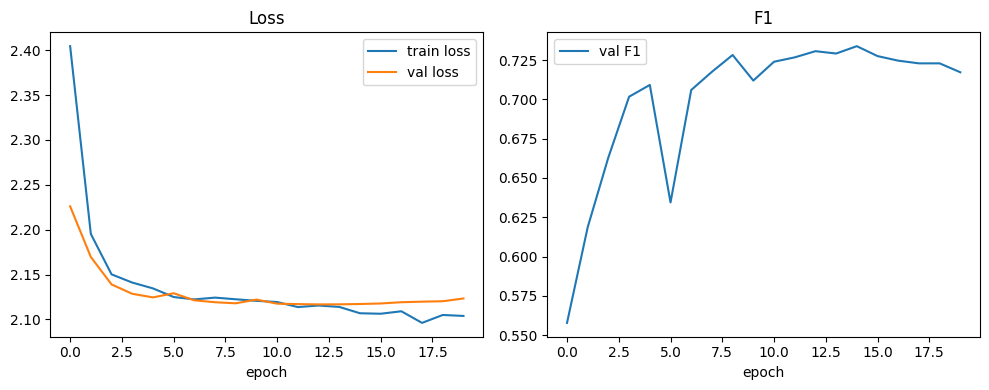


🏆 Best val loss: 2.1168
🏆 Best val F1:   0.7338



In [44]:
import os, time
import torch, torch.nn as nn
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# ─── A) CONFIG ────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n▶ Using device: {device}\n")

in_ch = 14   # only original Sentinel-2 bands for now
model, loss_fn, optimizer = make_model(in_ch)
model.to(device)
print(model, "\n")

# quick sanity‐check on 1 batch
batch = next(iter(train_loader), None)
if batch:
    imgs, masks = batch
    imgs, masks = imgs.to(device), masks.to(device)
    model.train(); optimizer.zero_grad()
    loss = loss_fn(model(imgs), masks)
    loss.backward(); optimizer.step()
    print(f"✔ Sanity-check loss: {loss.item():.4f}\n")
else:
    print("⚠️ train_loader is empty!\n")

# ─── B) TRAIN/VAL LOOP ─────────────────────────────────────────────────────────
NUM_EPOCHS     = 20
CHECKPOINT_DIR = "./checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

best_val_loss = float("inf")
best_val_f1   = -1

train_losses, val_losses, val_f1s = [], [], []

for epoch in range(1, NUM_EPOCHS+1):
    t0 = time.time()
    # — Train —
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch{epoch:02d} Train", leave=False)
    for imgs, masks in pbar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss   = loss_fn(logits, masks)
        loss.backward(); optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        pbar.set_postfix(loss=f"{running_loss/((pbar.n+1)*imgs.size(0)):.4f}")
    train_loss = running_loss / len(train_loader.dataset)

    # — Validate —
    model.eval()
    running_loss = 0.0
    y_true, y_pred = [], []
    pbar = tqdm(val_loader, desc=f"Epoch{epoch:02d} Val  ", leave=False)
    with torch.no_grad():
        for imgs, masks in pbar:
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            loss   = loss_fn(logits, masks)
            running_loss += loss.item() * imgs.size(0)
            pbar.set_postfix(loss=f"{running_loss/((pbar.n+1)*imgs.size(0)):.4f}")

            probs = torch.sigmoid(logits).cpu().numpy().ravel()
            preds = (probs > 0.5).astype(int)
            y_true.append(masks.cpu().numpy().ravel().astype(int))
            y_pred.append(preds)
    val_loss = running_loss / len(val_loader.dataset)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    val_f1 = f1_score(y_true, y_pred, zero_division=0)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    msg = (f"[E{epoch:02d}] tr_loss={train_loss:.4f}  "
           f"val_loss={val_loss:.4f}  val_f1={val_f1:.4f}  "
           f"({time.time()-t0:.1f}s)")
    # best checkpoints
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR,
                    f"best-loss-epoch{epoch:02d}-{val_loss:.4f}.pth"))
        msg += "  ← best loss"
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR,
                    f"best-f1--epoch{epoch:02d}-{val_f1:.4f}.pth"))
        msg += "  ← best F1"

    print(msg)

# ─── C) PLOT CURVES & FINAL METRICS ─────────────────────────────────────────────
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="train loss")
plt.plot(val_losses,   label="val loss")
plt.legend(); plt.title("Loss"); plt.xlabel("epoch")

plt.subplot(1,2,2)
plt.plot(val_f1s, label="val F1")
plt.legend(); plt.title("F1"); plt.xlabel("epoch")
plt.tight_layout(); plt.show()

print(f"\n🏆 Best val loss: {best_val_loss:.4f}")
print(f"🏆 Best val F1:   {best_val_f1:.4f}\n")